In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
from PIL import Image
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.ops import box_iou
from tqdm import tqdm
import seaborn as sns

Creating a custom COCO Dataset from our annotation file and images...

In [ ]:
# Create a Custom COCO Dataset with Missing File Handling
class CustomCocoDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transforms=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        ''' Retrieve a single data item from the dataset at a given index (idx)'''
        image_id = self.image_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(ann_ids)

        img_info = self.coco.imgs[image_id]
        img_path = os.path.join(self.image_dir, img_info['file_name'])


        # Skip missing images silently
        if not os.path.exists(img_path):
            '''recursively calls __getitem__ again with the next index in the dataset, effectively skipping the missing image.
        The modulo operator (%) ensures that the index wraps around to the beginning of the dataset if it reaches the end. It creates a circular indexing behavior,
        allowing the data loader to cycle through the dataset continuously.This is a common pattern in data loading and processing for machine learn'''

            return self.__getitem__((idx + 1) % len(self.image_ids))

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            return self.__getitem__((idx + 1) % len(self.image_ids))

        image = np.array(image)

        height, width = img_info['height'], img_info['width']
        mask = np.zeros((height, width), dtype=np.uint8)

        boxes, labels, masks = [], [], []

        for ann in annotations:
            category_id = ann['category_id']
            segmentation = ann['segmentation']
            bbox = ann['bbox']

            x_min, y_min, w, h = bbox
            x_max, y_max = x_min + w, y_min + h
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(category_id)

            mask_temp = np.zeros((height, width), dtype=np.uint8)
            for seg in segmentation:
                poly = np.array(seg, np.int32).reshape((-1, 2))
                cv2.fillPoly(mask_temp, [poly], 1)

            masks.append(mask_temp)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

        target = {"boxes": boxes, "labels": labels, "masks": masks}

        if self.transforms:
            image = self.transforms(image)

        return image, target

Training and evaluating functions...

In [ ]:
# Model Setup
'''prepares the Mask R-CNN model to be fine-tuned on a custom dataset for object detection and instance segmentation tasks.'''
def get_model(num_classes):
    model = maskrcnn_resnet50_fpn(pretrained=True)

    model.roi_heads.detections_per_img = 1000  # Remove limit on detections

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_channels_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels_mask, 256 , num_classes)

    return model

# Training Function
def train_one_epoch(model, optimizer, train_loader):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        progress_bar.set_postfix(loss=losses.item())

    return epoch_loss / len(train_loader)

# Evaluation Function
@torch.no_grad()
def evaluate(model, val_loader):
    model.train()
    total_loss = 0
    progress_bar = tqdm(val_loader, desc="Validating", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        total_loss += loss.item()

    return total_loss / len(val_loader)

# Compute IoU for Test Dataset
@torch.no_grad()
def compute_iou(model, test_loader, iou_threshold=0.5):
    model.eval()
    ious = []

    for images, targets in tqdm(test_loader, desc="Computing IoU"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        predictions = model(images)

        for pred, target in zip(predictions, targets):
            ious.append(box_iou(pred["boxes"], target["boxes"]).max().item())

    return np.mean(ious) if ious else 0

# Compute mAP for Test Dataset
@torch.no_grad()
def compute_map(model, test_loader, iou_threshold=0.95):
    model.eval()
    all_preds, all_gts = [], []

    for images, targets in tqdm(test_loader, desc="Computing mAP"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        predictions = model(images)
        for pred, target in zip(predictions, targets):
            all_preds.append(pred["boxes"].cpu().numpy())
            all_gts.append(target["boxes"].cpu().numpy())

    return np.mean([box_iou(torch.tensor(p), torch.tensor(g)).max().item() for p, g in zip(all_preds, all_gts)]) if all_preds else 0

# Visualize the confusion matrix
@torch.no_grad()
def compute_confusion_matrix(model, test_loader, iou_threshold=0.5):
    model.eval()
    model.roi_heads.detections_per_img = 1000
    TP, FP, FN = 0, 0, 0  # Initialize counts

    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        predictions = model(images)

        for pred, target in zip(predictions, targets):
            gt_boxes = target["boxes"]
            pred_boxes = pred["boxes"]
            pred_scores = pred["scores"]

            if len(gt_boxes) == 0 and len(pred_boxes) == 0:
                continue  # No objects in GT or predictions

            if len(pred_boxes) == 0 and len(gt_boxes) > 0:
                FN += len(gt_boxes)
                continue

            if len(gt_boxes) == 0 and len(pred_boxes) > 0:
                FP += len(pred_boxes)
                continue

            # Compute IoU between predicted and ground truth boxes
            ious = box_iou(pred_boxes, gt_boxes)  # Shape: [num_pred, num_gt]

            # Find best matches
            pred_matched_iou, pred_matched_gt_idx = ious.max(dim=1)  # Max IoU per predicted box
            gt_matched_iou, gt_matched_pred_idx = ious.max(dim=0)  # Max IoU per ground truth box

            # True Positives: Predictions with IoU >= threshold
            tp_mask = pred_matched_iou >= iou_threshold
            TP += tp_mask.sum().item()

            # False Positives: Predictions that do not match any ground truth
            FP += (~tp_mask).sum().item()

            # False Negatives: Ground truth objects that were not matched
            fn_mask = gt_matched_iou < iou_threshold
            FN += fn_mask.sum().item()

    # Create Confusion Matrix
    confusion_matrix = np.array([[TP, FN], [FP, 0]])

    # Plot Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Detected", "Missed"], yticklabels=["Correct", "Wrong"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return TP, FP, FN



Let's train the model...

loading annotations into memory...
Done (t=3.18s)
creating index...
index created!


Computing mAP: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s]


Epoch 1/20 - Train Loss: 3.8240, Val Loss: 2.3175, IoU: 0.3461, mAP: 0.3461


Computing mAP: 100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


Epoch 2/20 - Train Loss: 2.5750, Val Loss: 2.5678, IoU: 0.8284, mAP: 0.8284


Computing mAP: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it]


Epoch 3/20 - Train Loss: 2.5868, Val Loss: 2.3495, IoU: 0.8030, mAP: 0.8030


Computing mAP: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Epoch 4/20 - Train Loss: 2.0758, Val Loss: 1.7526, IoU: 0.8651, mAP: 0.8651


Computing mAP: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


Epoch 5/20 - Train Loss: 1.5787, Val Loss: 1.5280, IoU: 0.9418, mAP: 0.9418


Computing mAP: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Epoch 6/20 - Train Loss: 1.3055, Val Loss: 1.1768, IoU: 0.9515, mAP: 0.9515


Computing mAP: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


Epoch 7/20 - Train Loss: 1.0806, Val Loss: 0.9626, IoU: 0.9692, mAP: 0.9692


Computing mAP: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Epoch 8/20 - Train Loss: 0.9190, Val Loss: 0.8865, IoU: 0.9651, mAP: 0.9651


Computing mAP: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Epoch 9/20 - Train Loss: 0.8191, Val Loss: 0.7166, IoU: 0.9824, mAP: 0.9824


Computing mAP: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Epoch 10/20 - Train Loss: 0.7103, Val Loss: 0.6756, IoU: 0.9756, mAP: 0.9756


Computing mAP: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


Epoch 11/20 - Train Loss: 0.6483, Val Loss: 0.5732, IoU: 0.9865, mAP: 0.9865


Computing mAP: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


Epoch 12/20 - Train Loss: 0.5922, Val Loss: 0.5251, IoU: 0.9903, mAP: 0.9903


Computing mAP: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


Epoch 13/20 - Train Loss: 0.5592, Val Loss: 0.5233, IoU: 0.9911, mAP: 0.9911


Computing mAP: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Epoch 14/20 - Train Loss: 0.5289, Val Loss: 0.4578, IoU: 0.9778, mAP: 0.9778


Computing mAP: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


Epoch 15/20 - Train Loss: 0.5036, Val Loss: 0.4708, IoU: 0.9928, mAP: 0.9928


Computing mAP: 100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Epoch 16/20 - Train Loss: 0.4778, Val Loss: 0.4887, IoU: 0.9854, mAP: 0.9854


Computing mAP: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Epoch 17/20 - Train Loss: 0.4509, Val Loss: 0.4197, IoU: 0.9864, mAP: 0.9864


Computing mAP: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Epoch 18/20 - Train Loss: 0.4382, Val Loss: 0.3930, IoU: 0.9826, mAP: 0.9826


Computing mAP: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Epoch 19/20 - Train Loss: 0.4186, Val Loss: 0.3882, IoU: 0.9862, mAP: 0.9862


Computing mAP: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Epoch 20/20 - Train Loss: 0.4139, Val Loss: 0.3826, IoU: 0.9799, mAP: 0.9799


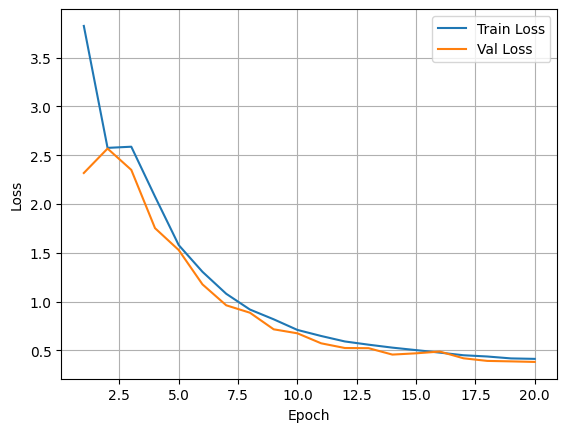

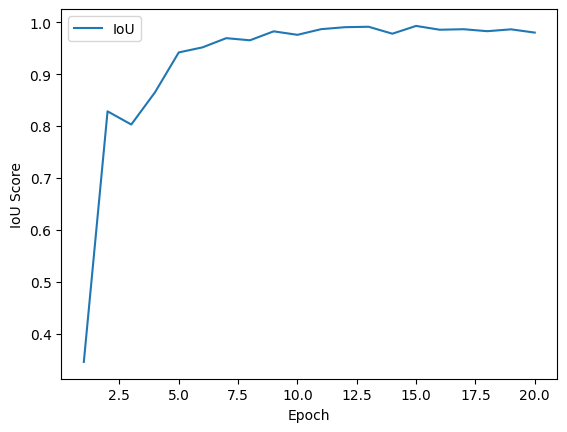

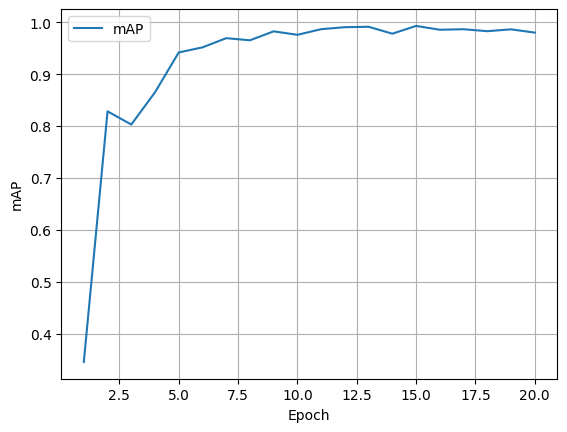

In [ ]:
# Dataset Paths
image_dir = "data\raw\original"
annotation_file = "data\raw\instances.json"
transform = transforms.Compose([transforms.ToTensor()])

# Load Dataset
dataset = CustomCocoDataset(image_dir, annotation_file, transforms=transform)

# Split Dataset
train_size, val_size = int(0.7 * len(dataset)), int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Training Setup
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

train_losses, val_losses, iou_scores, map_scores = [], [], [], []
best_iou, best_model_path = 0, None

# Training Loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader)
    val_loss = evaluate(model, val_loader)
    iou_score = compute_iou(model, test_loader)
    map_score = compute_map(model, test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    iou_scores.append(iou_score)
    map_scores.append(map_score)

    # Save model
    model_path = f"mask_rcnn_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), model_path)

    if iou_score > best_iou:
        best_iou = iou_score
        best_model_path = model_path

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, IoU: {iou_score:.4f}, mAP: {map_score:.4f}")

# Plot Loss and IoU
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), iou_scores, label="IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU Score")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), map_scores, label="mAP")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.legend()
plt.grid()
plt.show()





Confusion matrix...

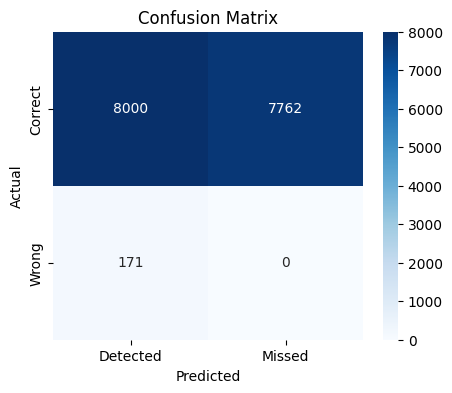

(8000, 171, 7762)

In [ ]:
compute_confusion_matrix(model, test_loader, iou_threshold=0.5)